In [8]:
from glob import glob
import pandas as pd
import json
from sklearn.metrics import confusion_matrix
import numpy as np

# Auswertung der generierten Daten

In [2]:
files = glob("C:/Users/AndreasEberl/Downloads/feedback/feedback/*.json")

In [3]:
files

['C:/Users/AndreasEberl/Downloads/feedback/feedback\\Anastasia.json',
 'C:/Users/AndreasEberl/Downloads/feedback/feedback\\Anett.json',
 'C:/Users/AndreasEberl/Downloads/feedback/feedback\\Eva.json',
 'C:/Users/AndreasEberl/Downloads/feedback/feedback\\Marcel.json',
 'C:/Users/AndreasEberl/Downloads/feedback/feedback\\Nicole.json',
 'C:/Users/AndreasEberl/Downloads/feedback/feedback\\Pascal.json',
 'C:/Users/AndreasEberl/Downloads/feedback/feedback\\Petra.json']

In [6]:
data = []

for file in files:
    with open(file, encoding = "utf-8") as f:
        data.extend(json.load(f))

In [136]:
sample_size = len(data)

answer_bool_vec_sample = list()
time_vec_sample = list()
ai_suggestion_picked_sample = list()
for i in range(sample_size):
    current_entry = data[i]
    answer_bool_vec = [subentry["isCorrect"] for subentry in current_entry["gameResults"]]
    answer_bool_vec_sample.append(answer_bool_vec)
    time_vec = [subentry["responseTime"] for subentry in current_entry["gameResults"]]
    time_vec_sample.append(time_vec)
    ai_suggestion_picked = [subentry["aiSuggestion"] == subentry["playerChoice"] for subentry in current_entry["gameResults"]]
    ai_suggestion_picked_sample.append(ai_suggestion_picked)

ai_mode_sample = [entry["aiMode"] for entry in data]

In [137]:
no_questions = 10
max_points_per_question = 10

def aux_lin_score(time_taken, max_til, min_from):
    if time_taken < max_til:
        return 1
    elif time_taken <= min_from:
        return 1 - (time_taken - max_til) / (min_from - max_til)
    else:
        return 0

def aux_nonlin_score(time_taken, scale, curve1, curve2):
    if time_taken > 0:
        return (1 + (time_taken / scale)**curve1)**(-curve2)
    else:
        return 1

def score(answer_bool_vec, time_vec, ai_mode, ai_suggestion_picked, scale = np.nan, curve1 = np.nan, curve2 = np.nan,
          min_time = np.nan, max_time = np.nan, max_bonus_prop = 1, nonlin = True):
    if ai_mode:
        if not (len(ai_suggestion_picked) == len(answer_bool_vec) == no_questions == len(time_vec)):
            return f"Fehler: Antwortvektor und Vektor der Zeiten pro Frage müssen Laenge {no_questions} haben"

    points_vec = np.zeros(no_questions)
    for i in range(no_questions):
        answer_bool = answer_bool_vec[i]
        time = time_vec[i]
        if nonlin:
            aux_score_val = aux_nonlin_score(time, scale, curve1, curve2)
        else:
            aux_score_val = aux_lin_score(time, min_time, max_time)
        pos_points = answer_bool * max_points_per_question * aux_score_val

        bonus_points = (1 - ai_suggestion_picked[i]) * answer_bool * max_points_per_question * max_bonus_prop * aux_score_val

        points_vec[i] = pos_points + bonus_points

    points_sum = sum(points_vec)
    if points_sum >= 0:
        return points_sum
    else:
        return 0

In [138]:
from scipy.optimize import minimize

max_bonus_prop = 1.0

def ai_difference_lin(params):
    min_time, max_time = params
    
    score_vec = list()
    for i in range(sample_size):
        score_vec.append(score(answer_bool_vec = answer_bool_vec_sample[i],
                               time_vec = time_vec_sample[i], 
                               ai_mode = ai_mode_sample[i],
                               ai_suggestion_picked = ai_suggestion_picked_sample[i],
                               min_time = min_time, max_time = max_time,
                               max_bonus_prop = max_bonus_prop, nonlin = False))
    
    inds_with_ai = [i for i, val in enumerate(ai_mode_sample) if val]
    scores_with_ai = [score_vec[i] for i in inds_with_ai]
    inds_sans_ai = [i for i, val in enumerate(ai_mode_sample) if not val]
    scores_sans_ai = [score_vec[i] for i in inds_sans_ai]

    return(np.mean(scores_sans_ai) - np.mean(scores_with_ai))


# Startwerte
x0 = [2.0, 10.0]

# Optionale Nebenbedingungen (z. B. alpha > 0)
bounds = [(1e-6, None), (1e-6, None)]  # untere Schranken > 0

constraints = [
    {"type": "ineq", "fun": lambda x: x[1] - x[0] - 5}       # b - a > 0 ⇔ a < b
]

# Minimierung
result_lin = minimize(ai_difference_lin, x0, bounds=bounds, constraints = constraints)

print(result_lin)


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -42.43331279922964
       x: [ 3.093e+00  8.093e+00]
     nit: 12
     jac: [-9.791e-01  9.655e-01]
    nfev: 44
    njev: 12


In [141]:
def ai_difference_nonlin(params):
    scale, curve1, curve2 = params
    
    score_vec = list()
    for i in range(sample_size):
        score_vec.append(score(answer_bool_vec = answer_bool_vec_sample[i],
                               time_vec = time_vec_sample[i], 
                               ai_mode = ai_mode_sample[i],
                               ai_suggestion_picked = ai_suggestion_picked_sample[i],
                               scale = scale, curve1 = curve1, curve2 = curve2,
                               max_bonus_prop = max_bonus_prop, nonlin = True))
    
    inds_with_ai = [i for i, val in enumerate(ai_mode_sample) if val]
    scores_with_ai = [score_vec[i] for i in inds_with_ai]
    inds_sans_ai = [i for i, val in enumerate(ai_mode_sample) if not val]
    scores_sans_ai = [score_vec[i] for i in inds_sans_ai]

    #return([np.mean(scores_sans_ai), np.mean(scores_with_ai)])
    return([scores_with_ai, scores_sans_ai])

# Startwerte
x0 = [5.0, 5.0, 1.0]

# Optionale Nebenbedingungen (z. B. alpha > 0)
bounds = [(1e-6, None), (1e-6, 10), (1e-6, 10)]  # untere Schranken > 0

# Minimierung
#result_nonlin = minimize(ai_difference_nonlin, x0, bounds=bounds, method='L-BFGS-B')

#print(result_nonlin)

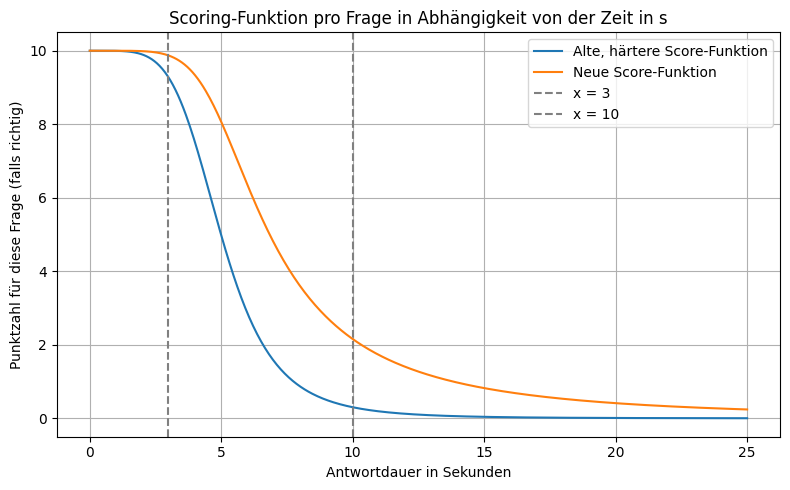

In [131]:
import matplotlib.pyplot as plt

# Parameter
#scale = 5.3   # Skalenparameter (Lage)
#curve1 = 6.0    # Linke Krümmung
#curve2 = 0.4    # Rechte Krümmung
scale = 3.8   # Skalenparameter (Lage)
curve1 = 10.0    # Linke Krümmung
curve2 = 0.22    # Rechte Krümmung


aux_nonlin_score_vec = np.vectorize(aux_nonlin_score)

# x-Werte
x = np.linspace(0.01, 25, 500)
y_old = 10*aux_nonlin_score_vec(x, 5.0, 5.0, 1.0)
y_new = 10*aux_nonlin_score_vec(x, 5.3, 6.0, 0.4)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, y_old, label='Alte, härtere Score-Funktion')
plt.plot(x, y_new, label='Neue Score-Funktion')
plt.axvline(x=3, color='gray', linestyle='--', linewidth=1.5, label='x = 3')
plt.axvline(x=10, color='gray', linestyle='--', linewidth=1.5, label='x = 10')
plt.title('Scoring-Funktion pro Frage in Abhängigkeit von der Zeit in s')
plt.xlabel('Antwortdauer in Sekunden')
plt.ylabel('Punktzahl für diese Frage (falls richtig)')
plt.ylim(-0.5, 10.5)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [150]:
score_diff_old_params = ai_difference_nonlin([5.0, 5.0, 1.0])
score_diff_new_params = ai_difference_nonlin([5.3, 6.0, 0.4])
print(f"Die Differenz der durchschnittlichen Scores mit KI minus ohne KI ist mit den alten Parameterwerten {score_diff_old_params} und mit den neuen Parameterwerten {score_diff_new_params}.")

scores_by_aiMode = ai_difference_nonlin([5.3, 6.0, 0.4])
for i, lst in enumerate(scores_by_aiMode):
    arr = np.array(lst)
    smallest = np.sort(arr)[:10]
    largest = np.sort(arr)[-10:]
    print(f"Liste {i+1}:")
    print("  Kleinste 10:", smallest)
    print("  Größte 10 :", largest)

Die Differenz der durchschnittlichen Scores mit KI minus ohne KI ist mit den alten Parameterwerten [[np.float64(45.99008420054962), np.float64(32.1153774703877), np.float64(93.00408460694504), np.float64(98.80437715860846), np.float64(99.72147269345012), np.float64(39.75150968974353), np.float64(73.89401280993565), np.float64(76.25104708611235), np.float64(73.78292369691798), np.float64(81.42700933022951), np.float64(15.386169362440489), np.float64(81.33449263395556), np.float64(73.24382046761137), np.float64(52.4262055388797), np.float64(87.35340133055327), np.float64(54.81289871005605), np.float64(77.86445084928599), np.float64(46.803801452706125), np.float64(82.05722725951972), np.float64(83.24258585023011), np.float64(87.99257577198331), np.float64(99.9929180773187), np.float64(85.43563516139474), np.float64(49.4282855706794), np.float64(67.67623626726548), np.float64(32.902585455723774), np.float64(53.410198783864374), np.float64(70.501346741088), np.float64(78.1405922586136), np.

45.11038961038961


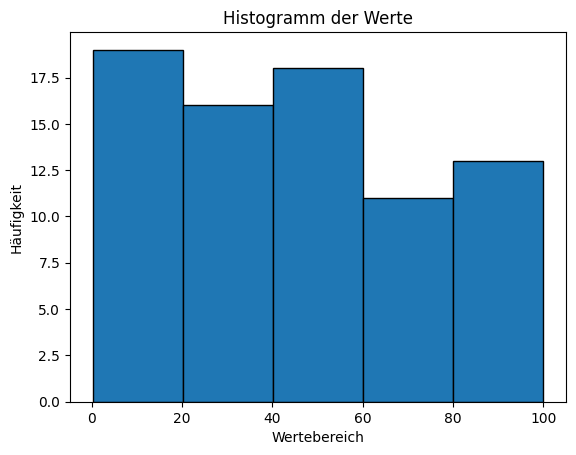

In [140]:

import matplotlib.pyplot as plt

score_vec = [entry["score"] for entry in data]

print(np.mean(score_vec))


plt.hist(score_vec, bins=5, edgecolor='black')

plt.xlabel('Wertebereich')
plt.ylabel('Häufigkeit')
plt.title('Histogramm der Werte')

plt.show()

In [189]:
feedback_data = []

for game_id, f in enumerate(feedback):
    for question_id, result in enumerate(f["gameResults"]):
        d = {col: val for col, val in f.items() if col != "gameResults"}
        d["game_id"] = game_id
        d["question_pos"] = question_id
        for col, value in result.items():
            d[col] = value
        feedback_data.append(d)

In [190]:
feedback_data = pd.DataFrame(feedback_data)

# Alle E-Mail-Adressen mit Namen auslesen

In [166]:
feedback_data[feedback_data["email"] != ""][["name", "email"]].drop_duplicates()

,name,email
240,Hase,anett.pohle-monetha@anacision.de
490,Marcel,marcel
550,Nicole,hello@gmail.com
560,Peter,peterlustig@yahoo.de
570,Gustav,gustav_gans@aol.com


# Auswertung

## Geschwindigkeit insgesamt mit und ohne KI

In [167]:
feedback_data.drop_duplicates("game_id").groupby("aiMode")["totalTime"].agg(
    ["mean", "median", "min", "max"]
)

,mean,median,min,max
aiMode,,,,
False,109.662791,90.80,14.1,294.9
True,57.485294,49.55,17.1,164.6


## Geschwindigkeit pro Frage mit und ohne KI

In [168]:
feedback_data.groupby("aiMode")["responseTime"].agg(["mean", "median", "min", "max"])

,mean,median,min,max
aiMode,,,,
False,9.977151,7.3235,0.060,68.663
True,4.810821,3.1460,0.578,46.331


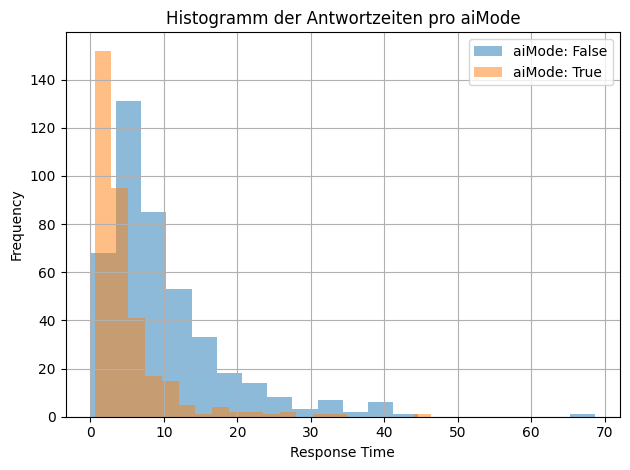

In [169]:
time_by_aiMode = feedback_data.groupby("aiMode")["responseTime"]
# Histogramme je aiMode zeichnen
for i, (mode, times) in enumerate(time_by_aiMode):
    plt.hist(
        times, 
        bins=20, 
        alpha=0.5, 
        label=f'aiMode: {mode}'
    )

# Achsenbeschriftung und Legende
plt.xlabel('Response Time')
plt.ylabel('Frequency')
plt.title('Histogramm der Antwortzeiten pro aiMode')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [170]:
for i, (mode, times) in enumerate(time_by_aiMode):
    quantiles = np.quantile(times, np.arange(0.1, 1.0, 0.1))
    print(f"Die Quantile für aiMode = {mode} sind {quantiles}")

Die Quantile für aiMode = False sind [ 2.7781  3.9314  5.1274  6.403   7.3235  9.2886 11.1164 14.2406 20.3492]
Die Quantile für aiMode = True sind [1.3803 1.8984 2.2151 2.6674 3.146  3.719  4.8376 6.499  9.7776]


# Anzahl der korrekten Antworten mit und ohne KI

In [171]:
feedback_data.drop_duplicates("game_id").groupby("aiMode")["correct"].agg(
    ["mean", "median", "min", "max"]
)

,mean,median,min,max
aiMode,,,,
False,8.465116,9.0,2,10
True,9.852941,10.0,8,10


## Werden Teilnehmende mit der Zeit schneller? (KI vs. ohne KI)

<Axes: title={'center': 'Durchschn. Antwortzeit pro Frage an Position (mit KI)'}, xlabel='Frageposition', ylabel='Antwortzeit in Sekunden'>

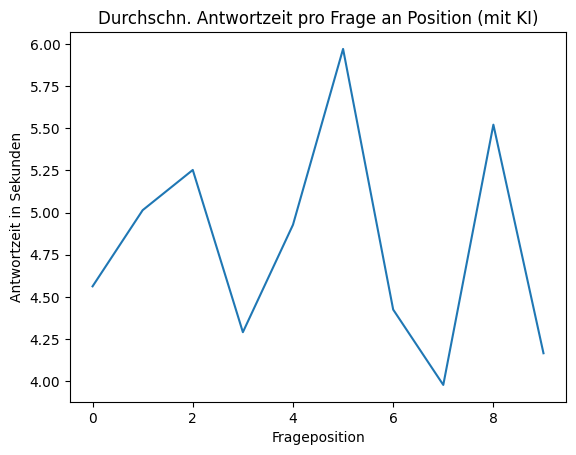

In [172]:
feedback_data[feedback_data["aiMode"]].groupby("question_pos")[
    "responseTime"
].mean().plot(
    title="Durchschn. Antwortzeit pro Frage an Position (mit KI)",
    xlabel="Frageposition",
    ylabel="Antwortzeit in Sekunden",
)

<Axes: title={'center': 'Durchschn. Antwortzeit pro Frage an Position (ohne KI)'}, xlabel='Frageposition', ylabel='Antwortzeit in Sekunden'>

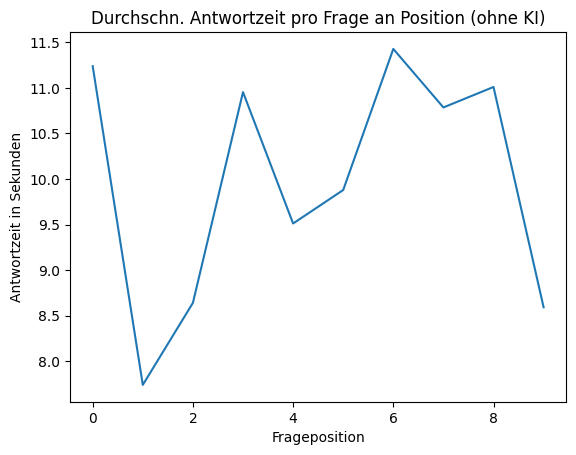

In [173]:
feedback_data[~feedback_data["aiMode"]].groupby("question_pos")[
    "responseTime"
].mean().plot(
    title="Durchschn. Antwortzeit pro Frage an Position (ohne KI)",
    xlabel="Frageposition",
    ylabel="Antwortzeit in Sekunden",
)

# Welche Kategorie wird wie oft getippt?

In [174]:
possible_depts = [
    "Finanzabteilung",
    "Rechtsabteilung",
    "Personalabteilung",
    "Leitungsebene",
    "Kundenservice",
]

In [194]:
# Assuming feedback_data is already defined
#incorrect_feedback = feedback_data[["correctDept", "playerChoice"]]

conf_matrix = confusion_matrix(
    feedback_data["correctDept"], feedback_data["playerChoice"], labels = possible_depts
)

conf_matrix_df = pd.DataFrame(conf_matrix, index=possible_depts, columns=possible_depts)

conf_matrix_df

,Finanzabteilung,Rechtsabteilung,Personalabteilung,Leitungsebene,Kundenservice
Finanzabteilung,124,7,4,6,0
Rechtsabteilung,2,140,3,2,10
Personalabteilung,0,1,176,2,4
Leitungsebene,2,2,8,148,7
Kundenservice,0,3,4,4,111


In [213]:
texts_of_interest = feedback_data[(feedback_data['correctDept'] =="Rechtsabteilung") & (feedback_data['playerChoice'] == "Kundenservice")]["text"]
for text in texts_of_interest:
    print(text)

Sehr geehrte Damen und Herren,

ich schreibe Ihnen, um auf ein ernstes Anliegen bezüglich meines Unternehmens, Meyer & Co. GmbH, aufmerksam zu machen. Unser Sitz ist in der Berliner Straße 45, 10115 Berlin. Im vergangenen Jahr, am 15. September, haben wir mehrfach versucht, ein bestimmtes Anliegen mit der Stadtverwaltung von Berlin zu klären. Leider blieben unsere Anfragen bis zum heutigen Tag unbeantwortet.

Wir haben gründlich alle internen Prozesse geprüft und sind zu dem Schluss gekommen, dass ein schwerwiegender Fehler seitens der Verwaltung in der Bearbeitung unserer Anliegen vorliegt. Uns liegt es fern, die Verbandsgemeinde in einem negativen Licht darzustellen. Dennoch haben die wiederholten Verzögerungen und Ausbleiben einer endgültigen Lösung unsere Geschäftsabläufe erheblich beeinträchtigt.

Falls eine Einigung in den nächsten zwei Wochen nicht erlangt wird, sehen wir uns gezwungen, alternative Maßnahmen in Betracht zu ziehen, um unser Anliegen zufriedenstellend zu lösen. Wi